# Multiple neighborhood MNCA training

In [1]:
import os
if not os.path.exists('/content/MNCA'):
    !git clone https://github.com/DaddarioLuigi/MNCA.git
    %cd MNCA
    !pip install -r requirements.txt
else:
    %cd /content/MNCA

Cloning into 'MNCA'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 178 (delta 99), reused 127 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (178/178), 6.11 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/MNCA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.9/618.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
import sys
sys.path.append('/content/MNCA')

## Verify GPU

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Mount colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Utility functions

In [ ]:
def make_update_net_fn(device):
    def update_net_wrapper(n_channels, hidden_dims=128, n_channels_out=None, device_arg=None):
        return classification_update_net(n_channels, hidden_dims, n_channels_out, device=device)
    return update_net_wrapper

In [ ]:
def build_models(nb_size, device, legacy=False):
    """Crea i 4 modelli per una certa neighborhood size."""
    # I modelli legacy usano sempre neighborhood_size = 3
    effective_nb_size = 3 if legacy else nb_size

    common_kwargs = dict(
        hidden_dim=128,
        maintain_seed=False,
        use_alive_mask=False,
        state_dim=6,
        residual=False,
        neighborhood_size=effective_nb_size,
        device=device,
    )

    nca = ExtendedNCA(
        update_net=classification_update_net(6 * 3, n_channels_out=6),
        **common_kwargs,
    )

    gca = ExtendedNCA(
        update_net=classification_update_net(6 * 3, n_channels_out=6 * 2),
        distribution="normal",
        **common_kwargs,
    )

    mix_nca = ExtendedMixtureNCA(
        update_nets=classification_update_net,
        num_rules=5,
        temperature=3,
        **common_kwargs,
    )

    stochastic_mix_nca = ExtendedMixtureNCANoise(
        update_nets=classification_update_net,
        num_rules=5,
        temperature=3,
        **common_kwargs,
    )

    return {
        "nca": nca,
        "gca": gca,
        "mix_nca": mix_nca,
        "stochastic_mix_nca": stochastic_mix_nca,
    }

In [ ]:
def load_model_weights(models, model_dir, legacy=False):
    """Carica i pesi dei 4 modelli dal model_dir corretto."""
    if legacy:
        filenames = {
            "nca": "nca_biological_simulation.pth",
            "gca": "nca_model_with_noise.pt",
            "mix_nca": "mix_nca_biological_simulation.pth",
            "stochastic_mix_nca": "stochastic_mix_nca_biological_simulation.pth",
        }
    else:
        filenames = {
            "nca": "standard_nca.pt",
            "gca": "nca_with_noise.pt",
            "mix_nca": "mixture_nca.pt",
            "stochastic_mix_nca": "stochastic_mix_nca.pt",
        }

    for name, model in models.items():
        path = os.path.join(model_dir, filenames[name])
        model.load_state_dict(torch.load(path, weights_only=True))

## Generate Histories

In [5]:
if os.path.exists('/content/drive/MyDrive/MNCA/histories.npy'):
    print("Caricando histories da Drive...")
    histories = np.load('/content/drive/MyDrive/MNCA/histories.npy')
    !cp /content/drive/MyDrive/histories.npy /content/MNCA/notebooks/histories.npy
else:
    print("Generando histories (richiede tempo)...")
    from generate_histories import generate_histories
    generate_histories('/content/MNCA/notebooks/histories.npy', n_simulations=200, n_steps=35)
    histories = np.load('/content/MNCA/notebooks/histories.npy')
    !cp /content/MNCA/notebooks/histories.npy /content/drive/MyDrive/

print(f"Setup completato! Histories caricate: {len(histories)} simulazioni")

Caricando histories da Drive...
cp: cannot stat '/content/drive/MyDrive/histories.npy': No such file or directory
Setup completato! Histories caricate: 200 simulazioni


### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# reload in jupyter
%load_ext autoreload
%autoreload 2

from mix_NCA.utils_simulations import grid_to_channels_batch, train_nca_dyn, plot_nca_prediction, classification_update_net, plot_nca_prediction2, plot_automata_comparison_grid, classification_update_net_unorm
from mix_NCA.ExtendedNCA import ExtendedNCA
from mix_NCA.ExtendedMixtureNCA import ExtendedMixtureNCA
from mix_NCA.TissueModel import ComplexCellType, TissueModel, create_complex_model_example, plot_cell_type_evolution
from mix_NCA.ExtendedMixtureNCANoise import ExtendedMixtureNCANoise


from mix_NCA.NCA import NCA
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.MixtureNCANoise import MixtureNCANoise

# set seed
np.random.seed(3)


## Input generation

The code below plots an example of generated history

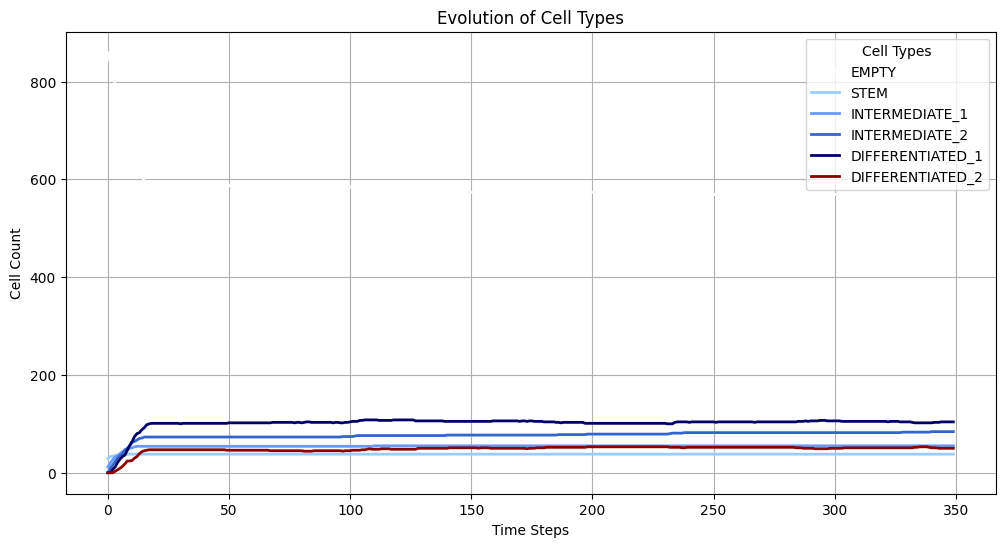

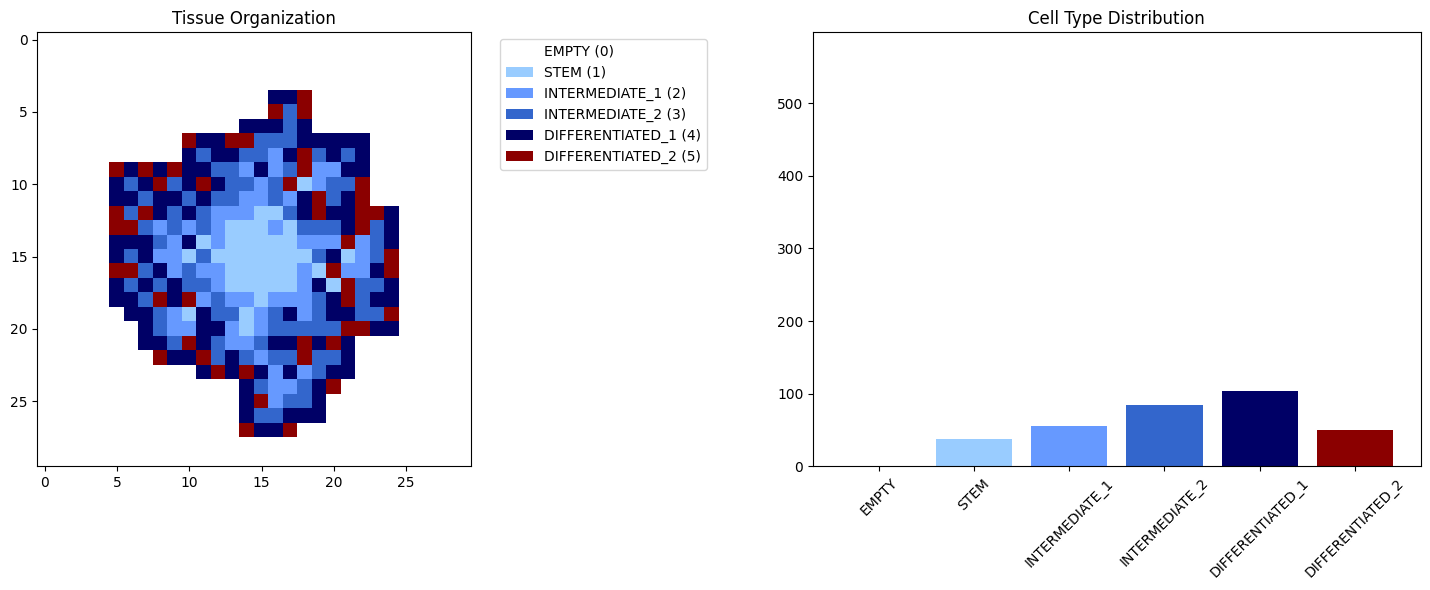

In [ ]:
# Create and run model
model = create_complex_model_example(15)

# Run simulation
steps = 1000
history = []
for _ in range(steps):
    model.step()
    history.append(model.grid.copy())

# Plot results
plot_cell_type_evolution(history)

# Plot final state
model.plot_tissue(show_statistics=True)


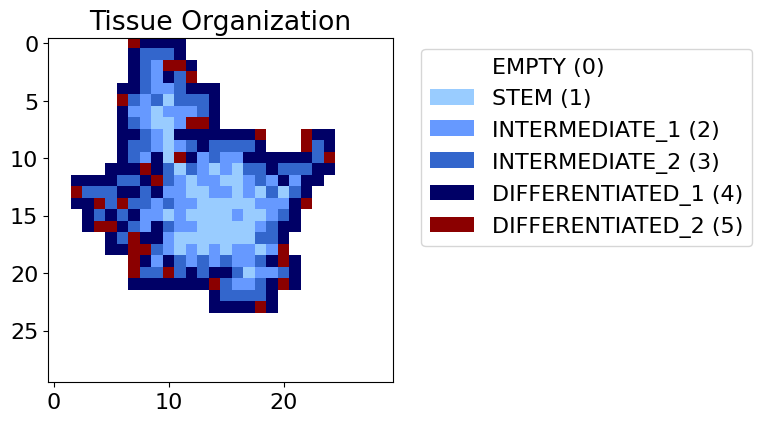

In [10]:
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams['font.size'] = 16

spatial_models[6].plot_tissue(show_statistics=False)

## Model training for each neighborhood size

Questa cella allena tutti i modelli per ogni neighborhood size
Se vuoi saltare il training e usare modelli già addestrati, vai alla cella successiva

In [ ]:
# Histories già caricate nella cella di setup
# histories = np.load("histories.npy")  # Commentato - già caricato

NEIGHBORHOOD_SIZES = [1,2, 3, 4, 5, 6, 7]  # Modifica questa lista per testare diversi sizes
BASE_MODEL_DIR = "/content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended"
os.makedirs(BASE_MODEL_DIR, exist_ok=True)

# Hyperparameters
HIDDEN_DIM = 128
STATE_DIM = 6
N_RULES = 5
LEARNING_RATE = 0.001
TEMPERATURE = 5
MIN_TEMPERATURE = 0.1
ANNEAL_RATE = 0.006
N_EPOCHS = 800
TIME_LENGTH = 35
UPDATE_EVERY = 1

update_net_fn = make_update_net_fn(device)

In [12]:
for nb_size in NEIGHBORHOOD_SIZES:
    print(f"\n{'='*60}")
    print(f"=== Training models for Neighborhood Size: {nb_size}x{nb_size} ===")
    print(f"{'='*60}\n")

    exp_dir = os.path.join(BASE_MODEL_DIR, f"NB_{nb_size}")
    os.makedirs(exp_dir, exist_ok=True)

    # 1. Standard NCA
    std_path = os.path.join(exp_dir, 'standard_nca.pt')
    if os.path.exists(std_path):
        print(f"Found {std_path}, skipping Standard NCA (nb={nb_size}).")
    else:
        print(f"Training Standard NCA (nb={nb_size})...")
        nca = ExtendedNCA(
            update_net=classification_update_net(6 * 3, n_channels_out=6, device=device),
            hidden_dim=HIDDEN_DIM,
            maintain_seed=False,
            use_alive_mask=False,
            state_dim=STATE_DIM,
            residual=False,
            neighborhood_size=nb_size,
            device=device
        )
        train_nca_dyn(nca, histories, n_cell_types=6, n_epochs=N_EPOCHS,
                      time_length=TIME_LENGTH, update_every=UPDATE_EVERY,
                      device=device, lr=LEARNING_RATE)
        torch.save(nca.state_dict(), std_path)
        print(f" Saved Standard NCA to {std_path}")

    # 2. NCA with Noise (GCA)
    gca_path = os.path.join(exp_dir, 'nca_with_noise.pt')
    if os.path.exists(gca_path):
        print(f"Found {gca_path}, skipping NCA with Noise (nb={nb_size}).")
    else:
        print(f"\nTraining NCA with Noise (nb={nb_size})...")
        nca_with_noise = ExtendedNCA(
            update_net=classification_update_net(6 * 3, n_channels_out=6 * 2, device=device),
            hidden_dim=HIDDEN_DIM,
            maintain_seed=False,
            use_alive_mask=False,
            state_dim=STATE_DIM,
            residual=False,
            distribution="normal",
            neighborhood_size=nb_size,
            device=device
        )
        nca_with_noise.random_updates = True
        train_nca_dyn(nca_with_noise, histories, n_cell_types=6, n_epochs=N_EPOCHS,
                      time_length=TIME_LENGTH, update_every=UPDATE_EVERY,
                      device=device, lr=LEARNING_RATE / 10)
        torch.save(nca_with_noise.state_dict(), gca_path)
        print(f" Saved NCA with Noise to {gca_path}")

    # 3. Mixture NCA
    mix_path = os.path.join(exp_dir, 'mixture_nca.pt')
    if os.path.exists(mix_path):
        print(f"Found {mix_path}, skipping Mixture NCA (nb={nb_size}).")
    else:
        print(f"\nTraining Mixture NCA (nb={nb_size})...")
        mix_nca = ExtendedMixtureNCA(
            update_nets=update_net_fn,
            hidden_dim=HIDDEN_DIM,
            maintain_seed=False,
            use_alive_mask=False,
            state_dim=STATE_DIM,
            num_rules=N_RULES,
            residual=False,
            temperature=3,
            neighborhood_size=nb_size,
            device=device
        )
        train_nca_dyn(model=mix_nca, target_states=histories, n_cell_types=6,
                      n_epochs=N_EPOCHS, time_length=TIME_LENGTH, update_every=UPDATE_EVERY,
                      device=device, lr=LEARNING_RATE, temperature=TEMPERATURE,
                      min_temperature=MIN_TEMPERATURE, anneal_rate=ANNEAL_RATE,
                      loss_type="mse", straight_through=False)
        torch.save(mix_nca.state_dict(), mix_path)
        print(f" Saved Mixture NCA to {mix_path}")

    # 4. Stochastic Mixture NCA
    stoch_path = os.path.join(exp_dir, 'stochastic_mix_nca.pt')
    if os.path.exists(stoch_path):
        print(f"Found {stoch_path}, skipping Stochastic Mixture NCA (nb={nb_size}).")
    else:
        print(f"\nTraining Stochastic Mixture NCA (nb={nb_size})...")
        stochastic_mix_nca = ExtendedMixtureNCANoise(
            update_nets=update_net_fn,
            hidden_dim=HIDDEN_DIM,
            maintain_seed=False,
            use_alive_mask=False,
            state_dim=STATE_DIM,
            num_rules=N_RULES,
            residual=False,
            temperature=3,
            neighborhood_size=nb_size,
            device=device
        )
        train_nca_dyn(model=stochastic_mix_nca, target_states=histories, n_cell_types=6,
                      n_epochs=N_EPOCHS, time_length=TIME_LENGTH, update_every=UPDATE_EVERY,
                      device=device, lr=LEARNING_RATE, milestones=[500], gamma=0.1,
                      temperature=TEMPERATURE, min_temperature=MIN_TEMPERATURE,
                      anneal_rate=ANNEAL_RATE)
        torch.save(stochastic_mix_nca.state_dict(), stoch_path)
        print(f" Saved Stochastic Mixture NCA to {stoch_path}")

    print(f"\n Completed training for neighborhood size {nb_size}x{nb_size}\n")

print(f"\n{'='*60}")
print("Training completato per tutti i neighborhood sizes!")
print(f"{'='*60}")


=== Training models for Neighborhood Size: 4x4 ===

Training Standard NCA (nb=4)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [03:36<00:00,  3.69it/s, loss=0.029366, window=0-35]


 Saved Standard NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_4/standard_nca.pt

Training NCA with Noise (nb=4)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [04:16<00:00,  3.12it/s, loss=0.004761, window=0-35]


 Saved NCA with Noise to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_4/nca_with_noise.pt

Training Mixture NCA (nb=4)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:03<00:00,  1.58s/it, loss=0.012935, window=0-35]


 Saved Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_4/mixture_nca.pt

Training Stochastic Mixture NCA (nb=4)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:37<00:00,  1.62s/it, loss=0.013551, window=0-35]


 Saved Stochastic Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_4/stochastic_mix_nca.pt

 Completed training for neighborhood size 4x4


=== Training models for Neighborhood Size: 5x5 ===

Training Standard NCA (nb=5)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [03:35<00:00,  3.72it/s, loss=0.029290, window=0-35]


 Saved Standard NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_5/standard_nca.pt

Training NCA with Noise (nb=5)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [04:16<00:00,  3.12it/s, loss=0.004699, window=0-35]


 Saved NCA with Noise to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_5/nca_with_noise.pt

Training Mixture NCA (nb=5)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [20:59<00:00,  1.57s/it, loss=0.001845, window=0-35]


 Saved Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_5/mixture_nca.pt

Training Stochastic Mixture NCA (nb=5)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:35<00:00,  1.62s/it, loss=0.001840, window=0-35]


 Saved Stochastic Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_5/stochastic_mix_nca.pt

 Completed training for neighborhood size 5x5


=== Training models for Neighborhood Size: 6x6 ===

Training Standard NCA (nb=6)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [03:44<00:00,  3.57it/s, loss=0.029484, window=0-35]


 Saved Standard NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_6/standard_nca.pt

Training NCA with Noise (nb=6)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [04:25<00:00,  3.01it/s, loss=0.004855, window=0-35]


 Saved NCA with Noise to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_6/nca_with_noise.pt

Training Mixture NCA (nb=6)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:14<00:00,  1.59s/it, loss=0.018685, window=0-35]


 Saved Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_6/mixture_nca.pt

Training Stochastic Mixture NCA (nb=6)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:48<00:00,  1.64s/it, loss=0.025965, window=0-35]


 Saved Stochastic Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_6/stochastic_mix_nca.pt

 Completed training for neighborhood size 6x6


=== Training models for Neighborhood Size: 7x7 ===

Training Standard NCA (nb=7)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [03:47<00:00,  3.52it/s, loss=0.029381, window=0-35]


 Saved Standard NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_7/standard_nca.pt

Training NCA with Noise (nb=7)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [04:29<00:00,  2.97it/s, loss=0.004850, window=0-35]


 Saved NCA with Noise to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_7/nca_with_noise.pt

Training Mixture NCA (nb=7)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:16<00:00,  1.60s/it, loss=0.002828, window=0-35]


 Saved Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_7/mixture_nca.pt

Training Stochastic Mixture NCA (nb=7)...
Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [21:50<00:00,  1.64s/it, loss=0.002034, window=0-35]

 Saved Stochastic Mixture NCA to /content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended/NB_7/stochastic_mix_nca.pt

 Completed training for neighborhood size 7x7


Training completato per tutti i neighborhood sizes!


## Plot reconstruction results

In [ ]:
NEIGHBORHOOD_SIZES = [1,2,3, 4, 5, 6, 7]
BASE_MODEL_DIR = "/content/drive/MyDrive/MNCA/results_extended/tissue_simulation_extended"
FALLBACK_MODEL_DIR = "/content/MNCA/models"

In [8]:
models_by_nb_size = {}

for nb_size in NEIGHBORHOOD_SIZES:
    print(f"\n{'='*60}")
    print(f"Loading models for Neighborhood Size: {nb_size}x{nb_size}")
    print(f"{'='*60}\n")

    model_dir = os.path.join(BASE_MODEL_DIR, f"NB_{nb_size}")
    legacy = False

    if not os.path.exists(model_dir):
        print(f"WARNING: Directory {model_dir} does not exist!")
        print(f"Falling back to original models in {FALLBACK_MODEL_DIR}")
        model_dir = FALLBACK_MODEL_DIR
        legacy = True

    # Crea modelli e carica pesi
    models = build_models(nb_size, device=device, legacy=legacy)
    load_model_weights(models, model_dir, legacy=legacy)

    # Settaggi comuni
    models["gca"].random_updates = True
    for m in models.values():
        m.eval()

    models_by_nb_size[nb_size] = models

    print(f" Loaded all models for neighborhood size {nb_size}x{nb_size}")

# Usa l’ultima neighborhood size come default
last_nb = NEIGHBORHOOD_SIZES[-1]
nca = models_by_nb_size[last_nb]["nca"]
gca = models_by_nb_size[last_nb]["gca"]
mix_nca = models_by_nb_size[last_nb]["mix_nca"]
stochastic_mix_nca = models_by_nb_size[last_nb]["stochastic_mix_nca"]

print(f"\n Using models with neighborhood size {last_nb}x{last_nb} for subsequent cells")
print("  (Modify NEIGHBORHOOD_SIZES or access models_by_nb_size[nb_size] to use different sizes)")


Loading models for Neighborhood Size: 3x3

 Loaded all models for neighborhood size 3x3

Loading models for Neighborhood Size: 4x4

 Loaded all models for neighborhood size 4x4

Loading models for Neighborhood Size: 5x5

 Loaded all models for neighborhood size 5x5

Loading models for Neighborhood Size: 6x6

 Loaded all models for neighborhood size 6x6

Loading models for Neighborhood Size: 7x7

 Loaded all models for neighborhood size 7x7

 Using models with neighborhood size 7x7 for subsequent cells
  (Modify NEIGHBORHOOD_SIZES or access models_by_nb_size[nb_size] to use different sizes)


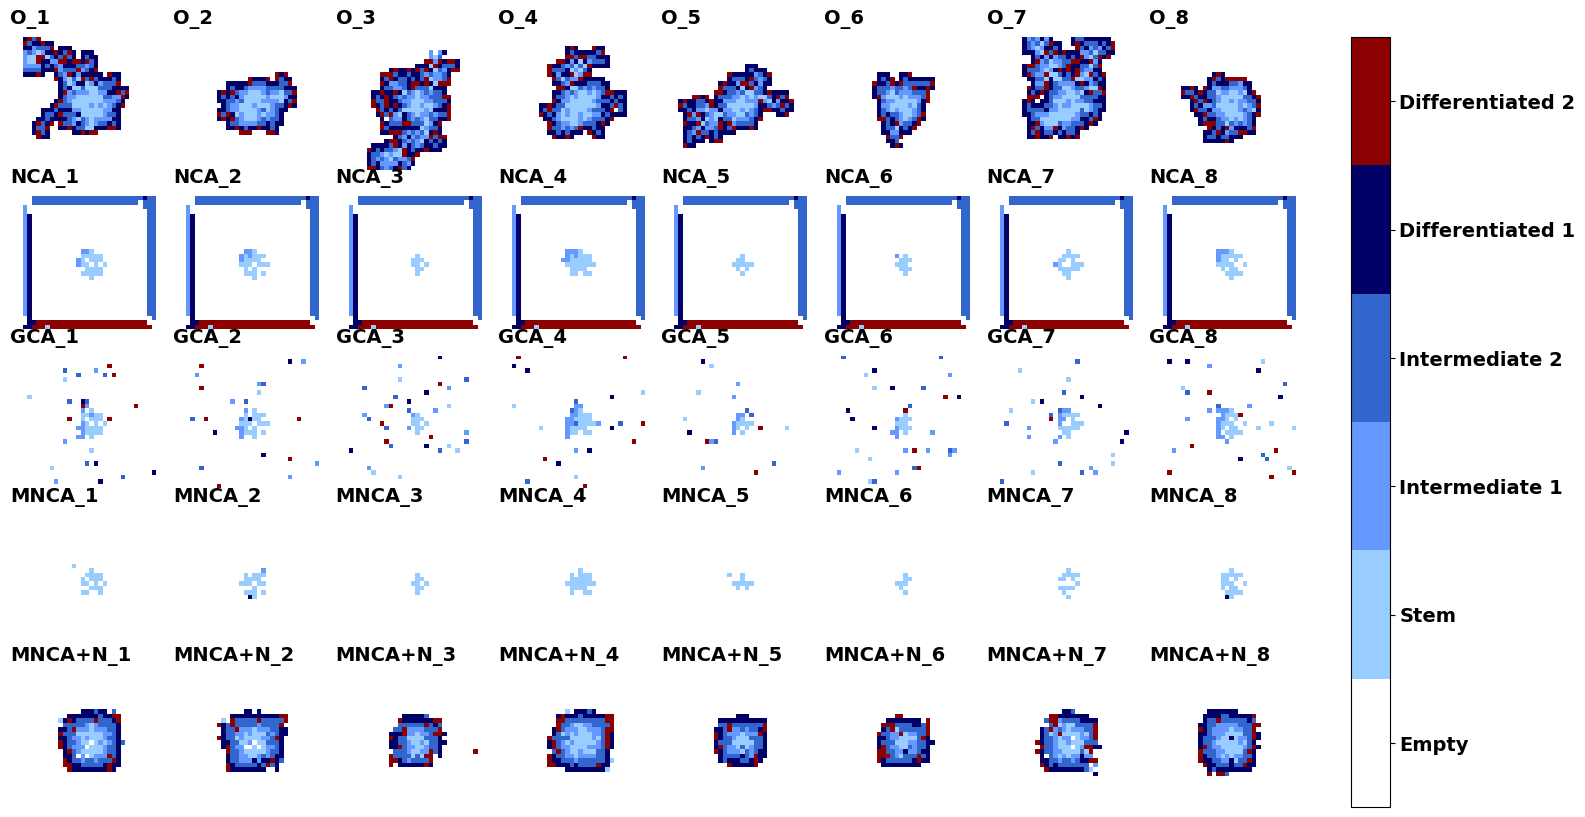

In [9]:
fig = plot_automata_comparison_grid(
    det_nca=nca.to(device),
    gca=gca.to(device),
    mix_nca=mix_nca.to(device),
    stoch_mix_nca=stochastic_mix_nca.to(device),
    initial_state=histories,
    n_examples=8,
    n_steps=35,
    figsize=(18, 10) ,
    device = device
)

# Crea directory figures se non esiste
os.makedirs('/content/MNCA/figures', exist_ok=True)
# Save the figure in high quality
fig.savefig('/content/MNCA/figures/automata_comparison.png', bbox_inches='tight', dpi=300)
# For vector graphics (recommended for papers):
fig.savefig('/content/MNCA/figures/automata_comparison.pdf', bbox_inches='tight', format='pdf')


<module 'matplotlib.pyplot' from '/home/salvatore.milite/miniconda3/envs/automata_project/lib/python3.11/site-packages/matplotlib/pyplot.py'>

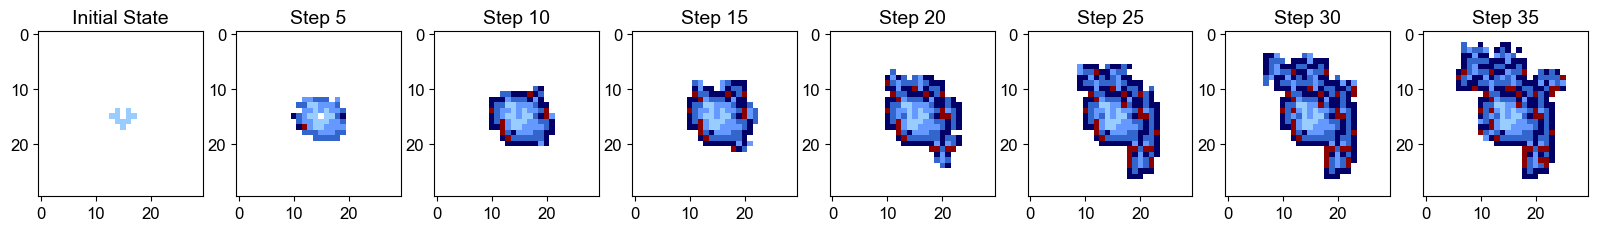

In [ ]:
fig = plot_nca_prediction2(stochastic_mix_nca, histories[3][0], steps=35, plot_every=5, device = device)


# Save the figure in high quality
fig.savefig('/content/MNCA/figures/automata_prediction.png', bbox_inches='tight', dpi=300)
# For vector graphics (recommended for papers):
fig.savefig('/content/MNCA/figures/automata_prediction.pdf', bbox_inches='tight', format='pdf')

## Rule assignment visualization

In [ ]:
x = grid_to_channels_batch(grids=histories[3],     n_cell_types=6, device = device)

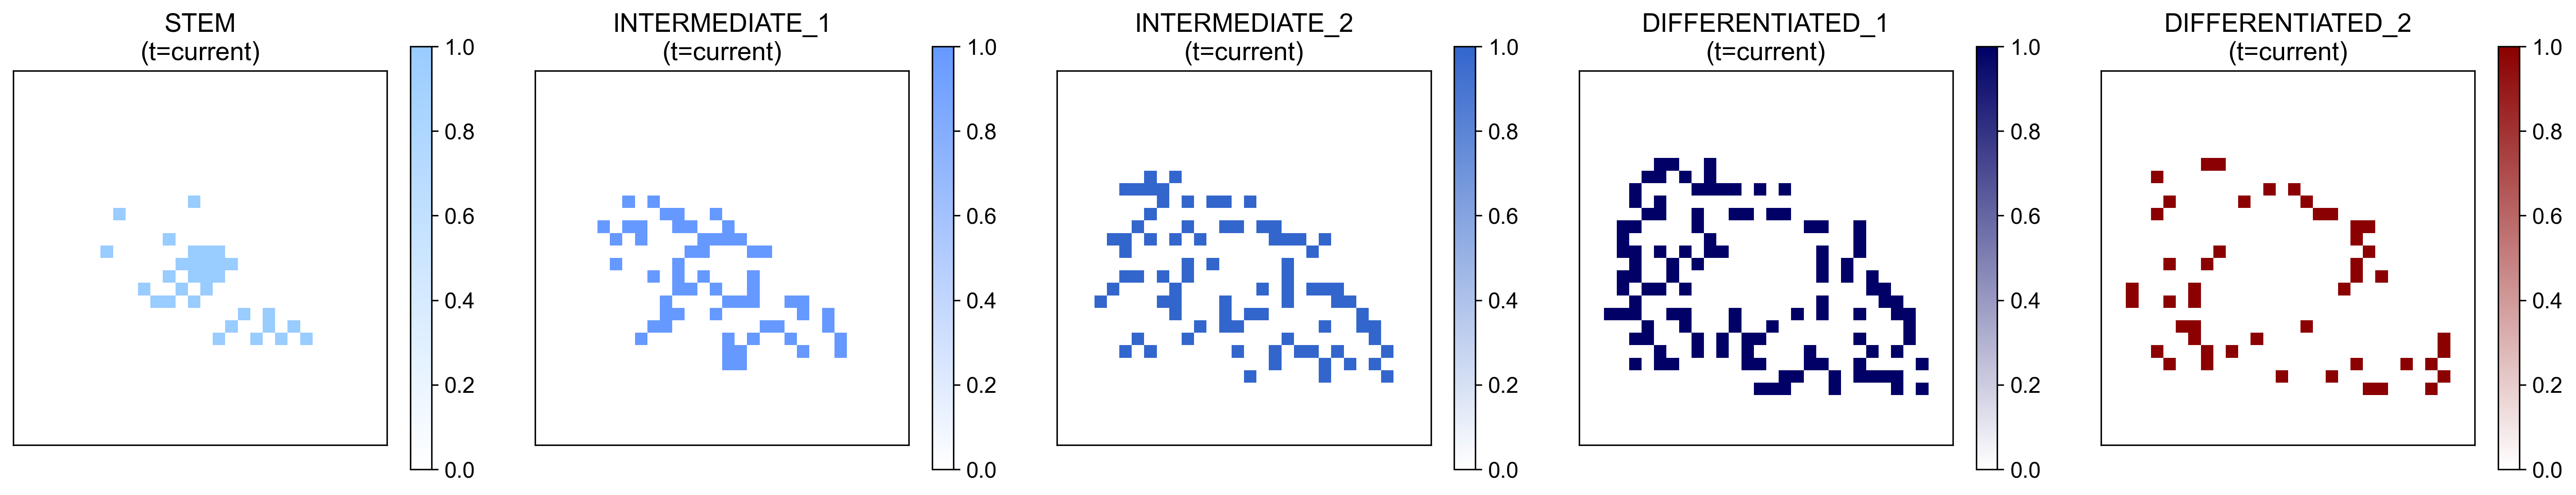

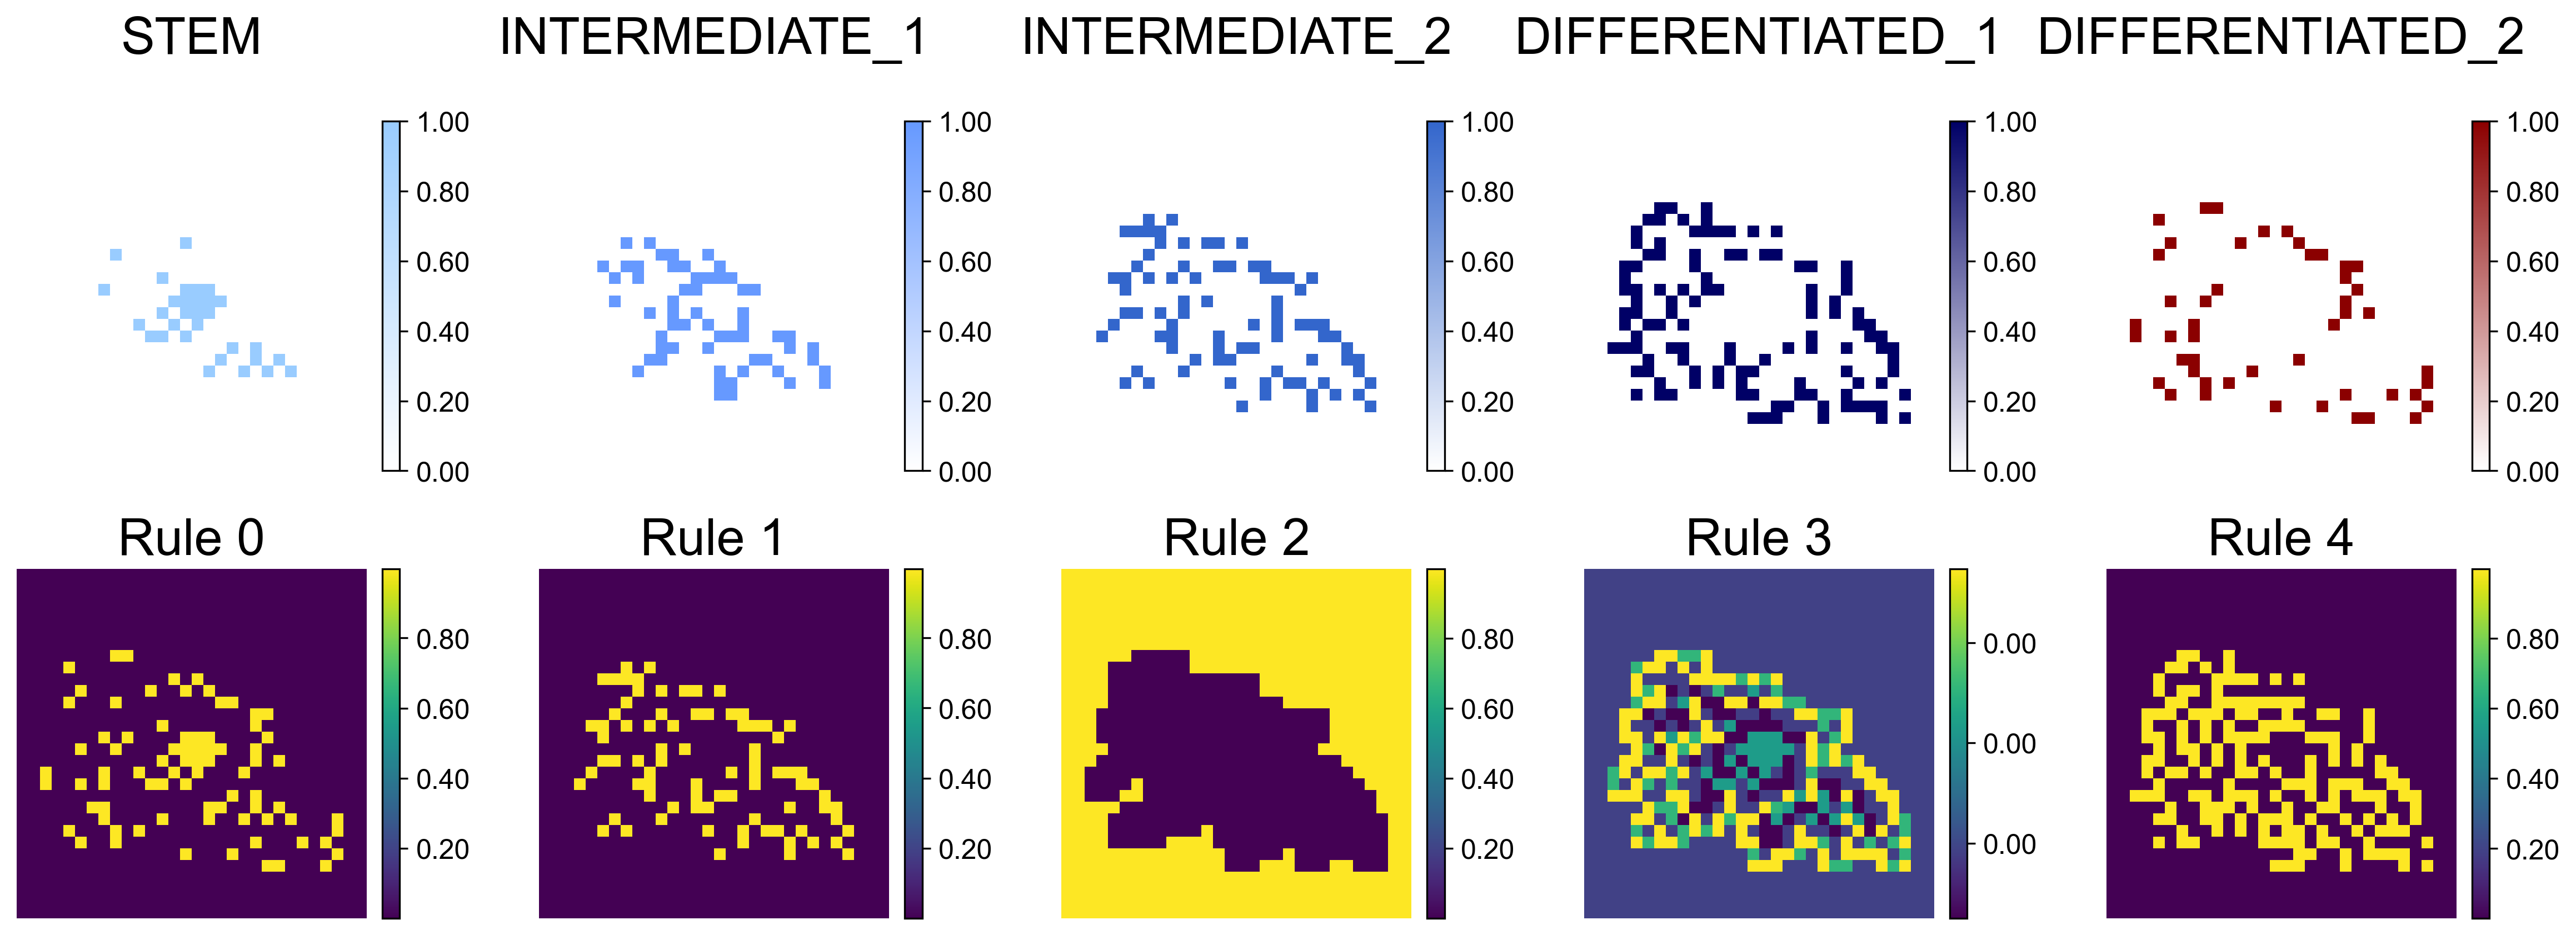

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 22

fig1 = spatial_models[3].plot_grid(separate_types=True, skip_empty=True)
fig2 = mix_nca.visualize_rule_assignments(x[34:])

fig, axes = plt.subplots(2, 5, figsize=(16, 6))

cell_types = [ct for ct in ComplexCellType if ct != ComplexCellType.EMPTY]


# Transfer images from fig1 to top row
for i in range(5):
    # Get image data from original figure
    img_data = fig1.get_axes()[i].get_images()[0].get_array()
    # Plot in new figure
    cell_type = cell_types[i]
    color_map = plt.cm.colors.LinearSegmentedColormap.from_list(
                    f"custom_{cell_type.name}",
                    ['white', cell_type.get_color()]
                )

    im = axes[0, i].imshow(img_data, cmap=color_map)
    # remove current from the title string
    axes[0, i].set_title(fig1.get_axes()[i].get_title().replace('(t=current)', ''),  fontsize=22)
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], format='%.2f', fraction=0.046, pad=0.04)

# Transfer images from fig2 to bottom row
for i in range(5):
    # Get image data from original figure
    img_data = fig2.get_axes()[i].get_images()[0].get_array()
    # Plot in new figure
    im = axes[1, i].imshow(img_data)
    axes[1, i].set_title(fig2.get_axes()[i].get_title(), fontsize=22)
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], format='%.2f', fraction=0.046, pad=0.04)

plt.tight_layout()

# Save the figure
plt.savefig('/content/drive/MyDrive/MNCA/figures/spatial_model_and_rule_assignments.pdf', bbox_inches='tight', dpi=600, format='pdf')

# Close the original figures to free memory
plt.close(fig1)
plt.close(fig2)

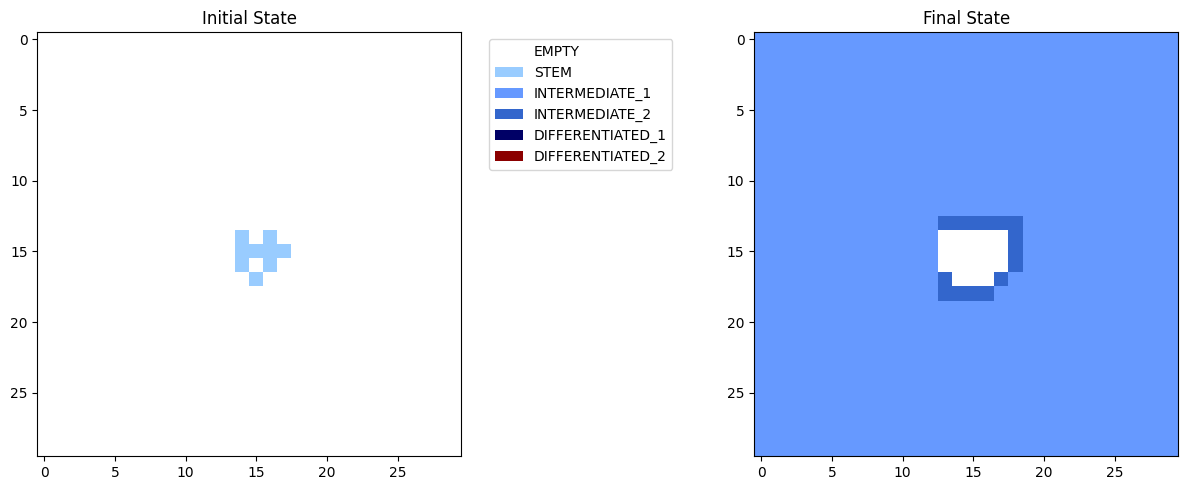

In [ ]:
plot_nca_prediction(ncas[1], histories[30][0], steps=4, n_cell_types=6, cell_type_enum=ComplexCellType, show_intermediate=False)